In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [2]:
df = pd.read_csv('./merged.csv', index_col=0)

In [3]:
df.head(10)

,Stkcd,Trdmnt,Mretwd,rf,rm
0,600000,2013-01-01,0.157258,0.002466,0.064975
1,600000,2013-02-01,-0.036585,0.002466,-0.005045
2,600000,2013-03-01,-0.084087,0.002466,-0.066675
3,600000,2013-04-01,-0.024679,0.002466,-0.019148
4,600000,2013-05-01,0.059717,0.002466,0.065018
5,600000,2013-06-01,-0.164966,0.002466,-0.155687
6,600000,2013-07-01,-0.050725,0.002466,-0.003462
7,600000,2013-08-01,0.143766,0.002466,0.055124
8,600000,2013-09-01,0.122358,0.002466,0.041111
9,600000,2013-10-01,0.023786,0.002466,-0.014661


In [4]:
import qgrid

In [7]:
qgrid_df = qgrid.show_grid(df, show_toolbar=True)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [8]:
qgrid_df

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [10]:
qgrid_df

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defaultColumnWidth': 150, 'rowHeight': 28, 'enableColumnReorder': False, 'enableTextSelectionOnCells': True, 'editable': True, 'autoEdit': False, 'explicitInitialization': True, 'maxVisibleRows': 15, 'minVisibleRows': 8, 'sortable': True, 'filterable': True, 'highlightSelectedCell': False, 'highlightSelectedRow': True, 'boldIndex': True}, id='1b12ad7a-bb77-4840-8238-ed349e447745', precision=5, show_toolbar=True)

### Drop stocks with list date later than 2013.01

In [4]:
all_stocks = pd.unique(df['Stkcd'])
valid_stocks = []

for stock in tqdm(all_stocks):
    first_idx = df[df['Stkcd']==stock]['Trdmnt'].first_valid_index()
    if df.loc[first_idx]['Trdmnt'] == '2013-01-01':
        valid_stocks.append(stock)
valid_stocks = np.array(valid_stocks)

100%|██████████| 1454/1454 [00:01<00:00, 904.87it/s]


In [5]:
pd.unique(df['Stkcd']).shape

(1454,)

In [6]:
df = df[np.isin(df['Stkcd'], valid_stocks)]

In [7]:
pd.unique(df['Stkcd']).shape

(930,)

### Drop missing values

In [8]:
# missing values
df[df['Mretwd'].isna()]

,Stkcd,Trdmnt,Mretwd,rf,rm
3952,600075,2016-12-01,NaN,0.001241,-0.064421
14042,600240,2016-12-01,NaN,0.001241,-0.064421
19181,600327,2016-12-01,NaN,0.001241,-0.064421
21210,600363,2016-12-01,NaN,0.001241,-0.064421
25184,600439,2016-12-01,NaN,0.001241,-0.064421
32232,600571,2016-12-01,NaN,0.001241,-0.064421
56905,601100,2016-12-01,NaN,0.001241,-0.064421
57345,601116,2016-12-01,NaN,0.001241,-0.064421


In [9]:
df = df.dropna()

In [10]:
stock_codes = pd.unique(df['Stkcd'])

stock_dfs = []
stock_betas = []

for stock in stock_codes:
    stock_dfs.append(df[df['Stkcd']==stock])

In [11]:
Regression_df = pd.DataFrame({'Stock': [], "Alpha": [], "Beta": [], "ri-rf": []})

In [12]:
Regression_df['Stock'] = stock_codes

## First Pass Regression

Periodic cross-sectional regression, regress each stock across T periods:

$$ r_{it}-r_{ft} = \alpha_i+\beta_i(r_{mt}-r_{ft})+\epsilon_{it} $$

to calculate each stock's beta

### Sample regression with stock code 600900

In [13]:
stock_df = stock_dfs[900]
stock_df = stock_df.dropna(axis=0, how='any')
LR = LinearRegression()
ri = stock_df['Mretwd']
rf = stock_df['rf']
rm = stock_df['rm']
X = (rm-rf).values
X = X.reshape((X.shape[0],1))
y = (ri-rf).values
y = y.reshape((y.shape[0],1))
LR.fit(X,y)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

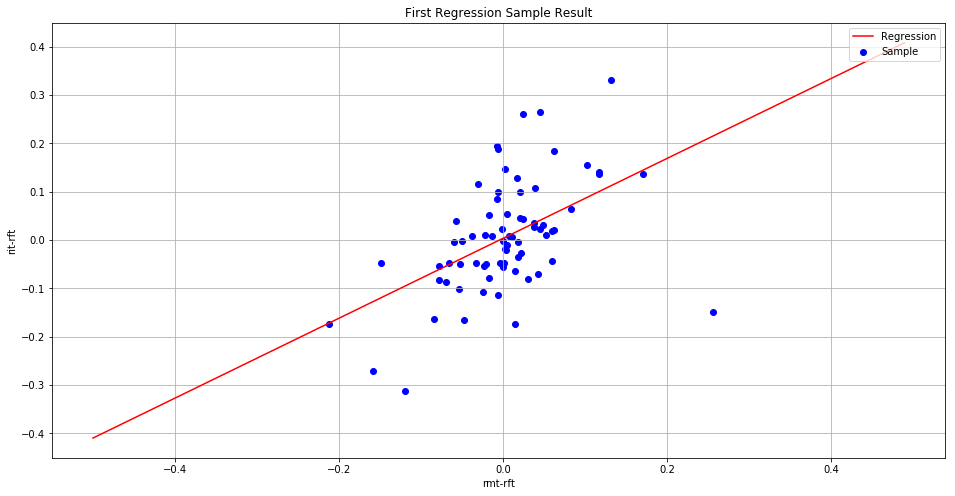

In [14]:
fig = plt.figure(figsize=(16,8))

plt.title("First Regression Sample Result")
plt.scatter(X,y, color='b', label='Sample')
plt.plot(np.arange(-0.5,0.5,0.01), LR.predict(np.arange(-0.5,0.5,0.01).reshape((-1,1))), color='r', label='Regression')
plt.grid(True)
plt.xlabel("rmt-rft")
plt.ylabel("rit-rft")
plt.legend(loc=1)
plt.savefig('Q1.2(a).png')

### First Pass Regression for all stocks

In [15]:
for idx in range(Regression_df.shape[0]):
    try:
        stock_df = stock_dfs[idx]
        stock_df = stock_df.dropna(axis=0, how='any')
        LR = LinearRegression()
        ri = stock_df['Mretwd']
        rf = stock_df['rf']
        rm = stock_df['rm']
        X = (rm-rf).values
        X = X.reshape((X.shape[0],1))
        y = (ri-rf).values
        y = y.reshape((y.shape[0],1))
        LR.fit(X,y)
        row = Regression_df.iloc[idx]
        row['Alpha'] = LR.intercept_
        row['Beta'] = LR.coef_
        row['ri-rf'] = np.mean(y)
        Regression_df.iloc[idx] = row
    except ValueError:
        print("ValueError with stock idx=%d\n"%idx)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A va

In [16]:
Regression_df.head()

,Stock,Alpha,Beta,ri-rf
0,600000.0,0.006729,0.691666,0.008905
1,600004.0,0.011361,0.870127,0.014099
2,600005.0,0.004312,1.048718,0.011767
3,600006.0,0.009654,0.656346,0.010664
4,600007.0,0.002727,0.711445,0.004965


### Stock with largest Beta

In [17]:
Regression_df.loc[Regression_df['Beta'].argmax()]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  """Entry point for launching an IPython kernel.


Stock    600090.000000
Alpha         0.022410
Beta          2.402965
ri-rf         0.011230
Name: 70, dtype: float64

### Stock with smallest Beta

In [18]:
Regression_df.loc[Regression_df['Beta'].argmin()]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  """Entry point for launching an IPython kernel.


Stock    600087.000000
Alpha        -0.047590
Beta         -1.767840
ri-rf        -0.038901
Name: 67, dtype: float64

## Second Pass Regression

Average cross-sectional regression:

$$ \overline{r_i-r_f} = \gamma_0+\gamma_1 b_i$$ 

If CAPM holds, then these is supposed to be $\gamma_0=0;\ \gamma1=\overline{r_m-r_f}$


Then test if $\gamma_0$ is significantly different from 0; if not so, it indicates that CAPM does not hold

In [19]:
LR = LinearRegression()
Regression_df = Regression_df.dropna()
X = Regression_df['Beta'].values
X = X.reshape((-1,1))
y = Regression_df['ri-rf'].values
y = y.reshape((-1,1))
LR.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [20]:
gamma0 = LR.intercept_
gamma1 = LR.coef_

### gamma0 in the second pass regression

In [21]:
gamma0.item()

0.004505888733599258

### gamma1 in the second pass regression

In [22]:
gamma1.item()

0.004698238835100429

### Mean value of the difference in market return and risk-free rate

In [23]:
rf = stock_df['rf']
rm = stock_df['rm']
np.mean((rm-rf).values)

0.003145763888888888

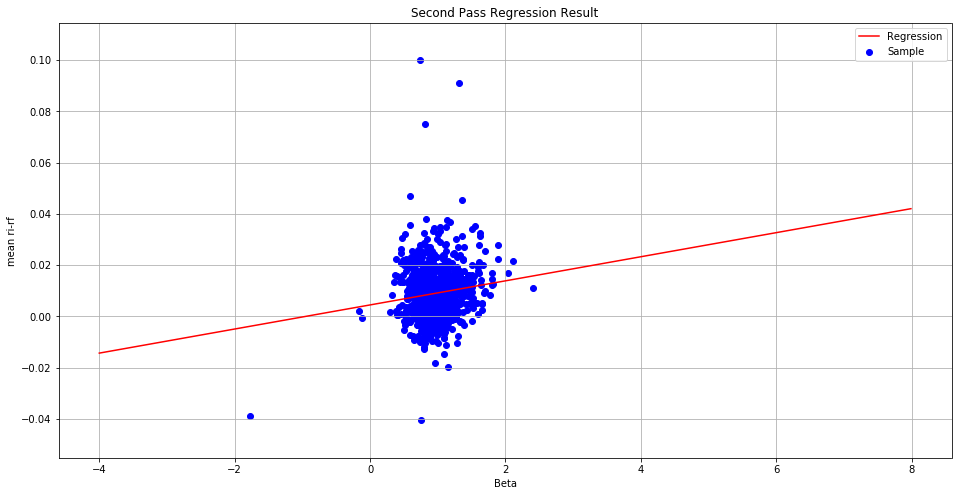

In [24]:
fig = plt.figure(figsize=(16,8))

plt.scatter(X,y, color='b', label='Sample')
plt.plot(np.arange(-4,8,0.01), LR.predict(np.arange(-4,8,0.01).reshape((-1,1))), color='r', label='Regression')
plt.grid(True)
plt.title("Second Pass Regression Result")
plt.xlabel("Beta")
plt.ylabel("mean ri-rf")
plt.legend(loc=1)
plt.savefig('Q1.2(b).png')

In [25]:
Regression_df.to_csv("RegressionResult.csv")

## Test CAPM

In [26]:
X = sm.add_constant(X)
model = sm.OLS(y,X)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     15.57
Date:                Sun, 10 Nov 2019   Prob (F-statistic):           8.55e-05
Time:                        16:17:51   Log-Likelihood:                 2931.5
No. Observations:                 930   AIC:                            -5859.
Df Residuals:                     928   BIC:                            -5849.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0045      0.001      3.773      0.000       0.002       0.007
x1             0.0047      0.001      3.946      0.000       0.002       0.007
==============================================================================
Omnibus:                      427.329   Durbin-Watson:                   1.926
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6352.656
Skew:                           1.701   Prob(JB):                         0.00
Kurtosis:                      15.344   Cond. No.                         6.89
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
hypotheses = 'const=0'
results.t_test(hypotheses)

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.0045      0.001      3.773      0.000       0.002       0.007

In [29]:
hypotheses = 'x1=0.003145763888888888'
results.t_test(hypotheses)

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.0047      0.001      1.304      0.193       0.002       0.007

## Conclusion
The hypothesis that $\gamma_0 = 0;\ \gamma_1=\overline{r_M-r_f}$ is rejected. CAPM does not hold